# Modeling — Random Forest Classifier

This notebook trains a Random Forest to predict churn using `../data/clean_data_with_features.csv`. It includes basic preprocessing, train/test split, training, evaluation, and feature importance. Adjust paths if your notebook location differs.

In [1]:
# 1. Imports
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
%matplotlib inline

sns.set(color_codes=True)


In [2]:
# 2. Load data
data_path = Path('../data/clean_data_with_features.csv')
if not data_path.exists():
    raise FileNotFoundError(f"Required file not found: {data_path}. Please run feature engineering notebook to create it.")

df = pd.read_csv(data_path)
print('Loaded data shape:', df.shape)
display(df.head())

Loaded data shape: (14606, 57)


,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,margin_diff,avg_offpeak_price_var,std_offpeak_price_var,min_offpeak_price_var,max_offpeak_price_var,spread_offpeak_var,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,estimated_annual_bill,price_sensitivity_proxy
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.0,0.124787,0.007829,0.117479,0.146033,0.028554,0.020057,3.700961,0.000000,0.000000
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.0,0.149609,0.002212,0.146033,0.151367,0.005334,-0.003767,0.177779,697.177552,-0.000000
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.0,0.170512,0.002396,0.167798,0.172468,0.004670,-0.004670,0.177779,92.758347,-0.000000
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.0,0.151210,0.002317,0.148586,0.153133,0.004547,-0.004547,0.177779,239.516772,-0.000000
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.0,0.124174,0.003847,0.119906,0.128067,0.008161,-0.006192,0.162916,549.471425,-3.256992


In [3]:
# Basic overview
print('Columns:', df.columns.tolist())
print('\nMissing values per column:')
display(df.isnull().sum().sort_values(ascending=False).head(20))

Columns: ['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'date_activ', 'date_end', 'date_modif_prod', 'date_renewal', 'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'var_year_price_off_peak_var', 'var_year_price_peak_var', 'var_year_price_mid_peak_var', 'var_year_price_off_peak_fix', 'var_year_price_peak_fix', 'var_year_price_mid_peak_fix', 'var_year_price_off_peak', 'var_year_price_peak', 'var_year_price_mid_peak', 'var_6m_price_off_peak_var', 'var_6m_price_peak_var', 'var_6m_price_mid_peak_var', 'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix', 'var_6m_price_mid_peak_fix', 'var_6m_price_off_peak', 'var_6m_price_peak', 'var_6m_price_mid_peak', 'churn', 'tenure_days', 'days_sin

cons_ratio_last_vs_year           117
channel_sales                       0
cons_12m                            0
cons_gas_12m                        0
cons_last_month                     0
date_activ                          0
date_end                            0
date_modif_prod                     0
id                                  0
forecast_cons_12m                   0
forecast_cons_year                  0
forecast_discount_energy            0
forecast_meter_rent_12m             0
forecast_price_energy_off_peak      0
forecast_price_energy_peak          0
forecast_price_pow_off_peak         0
has_gas                             0
imp_cons                            0
margin_gross_pow_ele                0
margin_net_pow_ele                  0
dtype: int64

In [4]:
# 3. Preprocessing
# Drop identifier column if present
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Ensure target exists
if 'churn' not in df.columns:
    raise ValueError('Target column churn not found in dataset.')

# Fill or drop na: simple approach for baseline
# Numeric columns: fill with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'churn']
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

# Categorical columns: fill with 'missing' and one-hot encode
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
for c in cat_cols:
    df[c] = df[c].fillna('missing').astype(str)

# One-hot encode categorical features (limit resulting dims)
if len(cat_cols) > 0:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print('After preprocessing shape:', df.shape)


After preprocessing shape: (14606, 4737)


In [5]:
# 4. Train/test split
from sklearn.model_selection import train_test_split

X = df.drop(columns=['churn'])
y = df['churn'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print('X_train', X_train.shape, 'X_test', X_test.shape)

X_train (10954, 4736) X_test (3652, 4736)


In [6]:
# 5. Train Random Forest
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print('Model trained.')

Model trained.


Accuracy: 0.9066265060240963
Precision: 0.7916666666666666
Recall: 0.05352112676056338
F1 score: 0.10026385224274406
ROC AUC: 0.6962548112453917


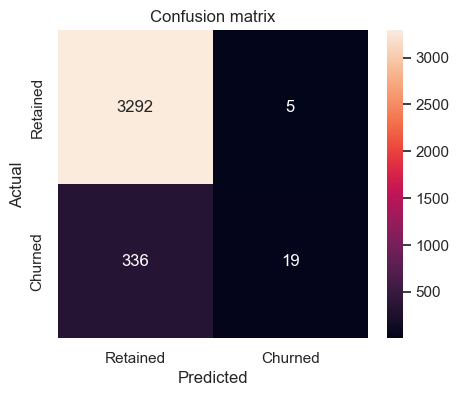

In [7]:
# 6. Evaluation
from sklearn import metrics

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('F1 score:', metrics.f1_score(y_test, y_pred))
print('ROC AUC:', metrics.roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Retained','Churned'], yticklabels=['Retained','Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

,feature,importance
12,margin_net_pow_ele,0.022589
11,margin_gross_pow_ele,0.021212
0,cons_12m,0.020947
46,estimated_annual_bill,0.020197
6,forecast_meter_rent_12m,0.020166
14,net_margin,0.019964
3,forecast_cons_12m,0.019905
16,pow_max,0.016625
37,cons_ratio_last_vs_year,0.016195
23,var_year_price_off_peak,0.016156


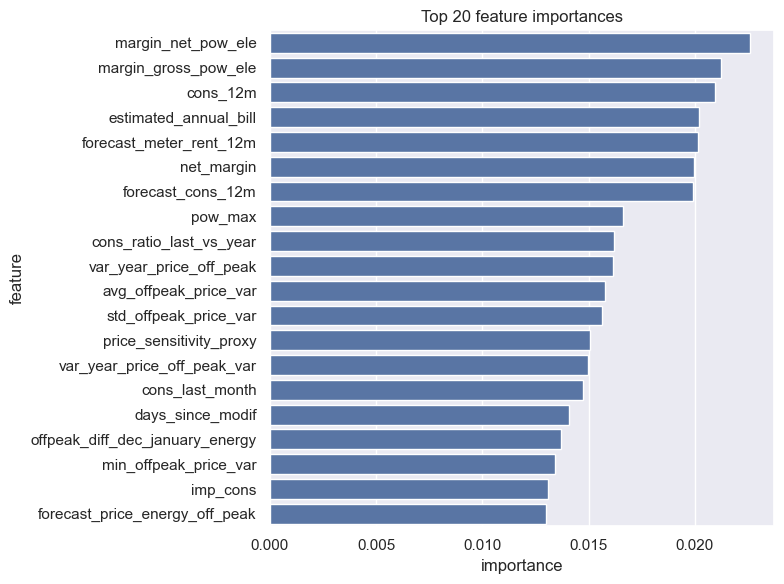

In [8]:
# 7. Feature importance
import pandas as pd

feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

display(feat_imp.head(20))

plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp.head(20), x='importance', y='feature')
plt.title('Top 20 feature importances')
plt.tight_layout()
plt.show()

In [9]:
# 8. Save model and metrics
import joblib
out_model = '../data/rf_model.joblib'
joblib.dump(model, out_model)
print('Saved model to', out_model)

metrics_dict = {
    'accuracy': metrics.accuracy_score(y_test, y_pred),
    'precision': metrics.precision_score(y_test, y_pred),
    'recall': metrics.recall_score(y_test, y_pred),
    'f1': metrics.f1_score(y_test, y_pred),
    'roc_auc': metrics.roc_auc_score(y_test, y_proba)
}
import json
with open('../data/model_metrics.json','w') as f:
    json.dump(metrics_dict, f)
print('Saved metrics to ../data/model_metrics.json')

Saved model to ../data/rf_model.joblib
Saved metrics to ../data/model_metrics.json


## Next steps

- Hyperparameter tuning (GridSearchCV or RandomizedSearchCV) to improve performance.
- Calibrate classifier probabilities if needed.
- Use cross-validation for more robust estimates.
- Consider class imbalance strategies (SMOTE, class_weight) if recall for churn is low.
